In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

plt.ion()   # 交互模式

transform = transforms.Compose([transforms.ToTensor()])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./cifar10/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
#(n+2p-f)/s + 1 向下取整，默认s=1，p=0
#即n-f+1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5) 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50) 
        self.fc2 = nn.Linear(50, 10)

        #-----stn 可插拔
        # Localisation Network小网络
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7), #32==26
            nn.MaxPool2d(2, stride=2), #26==13
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5), #13==9
            nn.MaxPool2d(2, stride=2), #9==4
            nn.ReLU(True)
        )

        # Localisation Network小网络，生成3 * 2 affine矩阵
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # 给转换矩阵初始化权重。[1,0,0][0,1,0] 是不做变换。
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        #-----stn 可插拔

    def stn(self, x):
        xs = self.localization(x) #32==>4，输出为（10，4，4）
        xs = xs.view(-1, 10 * 4 * 4) 
        theta = self.fc_loc(xs) #160==>6的全连接。
        theta = theta.view(-1, 2, 3) #2x3的变换网格。

        grid = F.affine_grid(theta, x.size()) #这玩意可以微分就很离谱。
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x) #仿射变换后尺寸不变（有黑边填充），作为一个模块可以插拔。

        # 普通卷积+全连接向前传播，跟stn无关了，只是为了完整实验能输出10个类的概率。
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) #32 28 14
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) #14 10 5
        x = x.view(-1, 500) #20*5*5
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [28]:
writer = SummaryWriter('runs/STN')
images, labels = next(iter(trainloader))
images = images.to(device)
writer.add_graph(model, images)
writer.close()

D:\Python\Python38\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
D:\Python\Python38\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
def train(epoch):
    running_loss = 0.0
    running_corrects = 0
    model.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device),data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        if i % 1000 == 999:  
            # writer.add_scalars("Losses!",{"train loss":running_loss / 1000},epoch * len(trainloader) + i)  
            print("train loss",running_loss / 1000)
            running_loss = 0.0
    # writer.add_scalars("Acces!",{"train acc":running_corrects / 1000},epoch * len(trainloader) + i)  
    print("train acc",running_corrects.cpu().numpy() / len(trainloader.dataset))
    exp_lr_scheduler.step()
def test(epoch):
    losses=0.0
    correct = 0
    with torch.no_grad():
        model.eval()
        for images, labels in testloader:
            images, labels = images.to(device),labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            losses+=loss.item()
            correct += (predicted == labels).sum().item()
    total = len(testloader.dataset)
    # writer.add_scalars("Losses!",{"test loss":losses / total},epoch * len(testloader))  
    # writer.add_scalars("Acces!",{"test acc":100 * correct / total},epoch * len(testloader))  
    print('Test Acc: %d %%' % (
        100 * correct / total))
    print('Test loss: %f' % (losses / total))

for epoch in range(5):
    train(epoch)
    test(epoch)
print('Finished Training')

D:\Python\Python38\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
D:\Python\Python38\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
train loss 2.0438125103712084
train acc 0.2648
Test Acc: 40 %
Test loss: 0.053213
train loss 1.7857834607362748
train acc 0.35016
Test Acc: 44 %
Test loss: 0.049289
train loss 1.7096541001796723
train acc 0.37716
Test Acc: 46 %
Test loss: 0.047102
train loss 1.67884563589

In [60]:
#看看每个类的正确率
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device),labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
 
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 100.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %


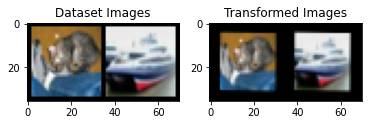

In [40]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
def visualize_stn():
    with torch.no_grad():
        data = next(iter(testloader))[0][0:2].to(device)
        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu() #直接调用stn即可
        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))
        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')
visualize_stn()

plt.ioff()
plt.show()